# Detección de la posición de la cabeza

En este notebook vamos a realizar una regresión sobre las imágenes del dataset [BIWI](https://data.vision.ee.ethz.ch/cvl/gfanelli/head_pose/head_forest.html#db) creado por Gabriele Fanelli et al., con el objetivo de detectar el centro de la cabeza de las personas que apareceran en las imágenes. Puedes descargar el dataset desde [aquí](https://s3.amazonaws.com/fast-ai-imagelocal/biwi_head_pose.tgz).

Empezamos por configurar el comportamento del notebook con los siguientes [*magic commands*](https://ipython.readthedocs.io/en/stable/interactive/magics.html/). Con ellos nos aseguramos de recargar de forma automática cualquier modificación de las librerías o de los gráficos.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Importamos el módulo 'vision' de la librería 'fastai'.

In [0]:
from fastai.vision import *

## Adquisición y conversión de datos

En 'path' cargamos los datos del dataset, a los que accedemos con la función 'untar_data'.

In [4]:
path = untar_data(URLs.BIWI_HEAD_POSE)

Cargamos los datos del archivo 'rgb.cal' con la función '[genfromtxt](https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html)' de la librería Numpy. Con 'skip_footer' saltamos las últimas 6 líneas.

In [5]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
cal

array([[517.679,   0.   , 320.   ],
       [  0.   , 517.679, 240.5  ],
       [  0.   ,   0.   ,   1.   ]])

En ' fname' cargamos una imagen de nuestro dataset.

In [0]:
fname = '09/frame_00667_rgb.jpg'

Creamos una función que creará el archivo de texto en el que registraremos las coordenadas del punto del centro de la cara.

In [0]:
def imgtxt_name(f): return path/f'{str(f)[:-7]}pose.txt'

En 'img' cargamos la imagen 'fname' y la mostramos con 'show()'.

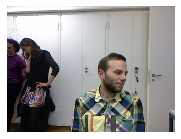

In [8]:
img = open_image(path/fname)
img.show()

En 'ctr' cargamos el resultado de la función 'img2txt_name' con la función 'genfromtxt' de la librería Numpy. Con 'skip_footer' saltamos las últimas 3 líneas.

Mostramos 'ctr'.

In [10]:
ctr = np.genfromtxt(imgtxt_name(fname), skip_header=3)
ctr

array([187.332 ,  40.3892, 893.135 ])

Con las siguientes 3 funciones los investigadores convierten las coordenadas en un tensor y a su vez en un punto.

In [0]:
def convert_biwi(coords):
    c1 = coords[0] * cal[0][0] / coords[2] + cal[0][2]
    c2 = coords[1] * cal[1][1] / coords[2] + cal[1][2]
    return tensor([c2,c1])

def get_ctr(f):
    ctr = np.genfromtxt(imgtxt_name(f), skip_header=3)
    return convert_biwi(ctr)

def get_ip(img,pts): return ImagePoints(FlowField(img.size, pts), scale=True)

Mostramos el tensor que nos devuelve la función 'get_ctr' cuando le pasamos la imagen.

In [24]:
get_ctr(fname)

tensor([263.9104, 428.5814])

Mostramos la misma imagen, pero esta vez con el punto que indica el centro de la cara.

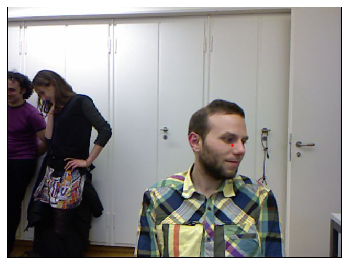

In [25]:
ctr = get_ctr(fname)
img.show(y=get_ip(img, ctr), figsize=(6,6))

## Creación de dataset

En 'data' creamos el 'databunch' con las transformaciones, el etiquetado y con las divisiones entre 'training set' y 'validation set'.

In [0]:
data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name=='13')
       .label_from_func(get_ctr)
       .transform(get_transforms(), tfm_y=True, size=(120,160))
       .databunch().normalize(imagenet_stats))

Mostramos unas imágenes a modo de comprobación.

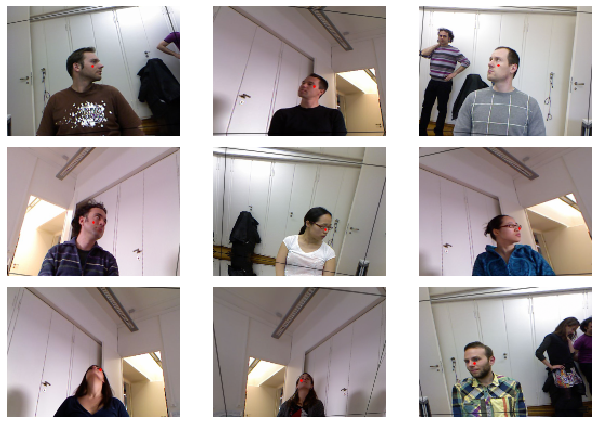

In [27]:
data.show_batch(3, figsize=(9,6))

## Entrenamiento del modelo

Creamos el modelo. Un red convolucional ('cnn_learner') con arquitectura ResNet34.

In [28]:
learn = cnn_learner(data, models.resnet34)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


Buscamos el *learning rate* y lo graficamos.

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


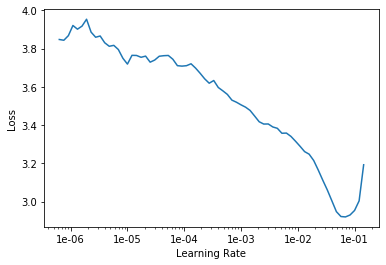

In [29]:
learn.lr_find()
learn.recorder.plot()

En 'lr' asignamos el *learning rate*.

In [0]:
lr = 2e-2

Entrenamos durante 5 épocas.

In [31]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,time
0,0.115248,0.005254,02:57
1,0.037844,0.009758,02:56
2,0.014019,0.005817,02:55
3,0.008451,0.001326,02:54
4,0.006368,0.001062,02:53


Guardamos el resultado del entrenamiento en 'stage-1'.

In [0]:
learn.save('stage-1')

Cargamos 'stage-1' y mostramos los resultados.

In [33]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (15193 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Valid: LabelList (485 items)
x: PointsItemList
Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160),Image (3, 120, 160)
y: PointsLabelList
ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160),ImagePoints (120, 160)
Path: /root/.fastai/data/biwi_head_pose;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, cei

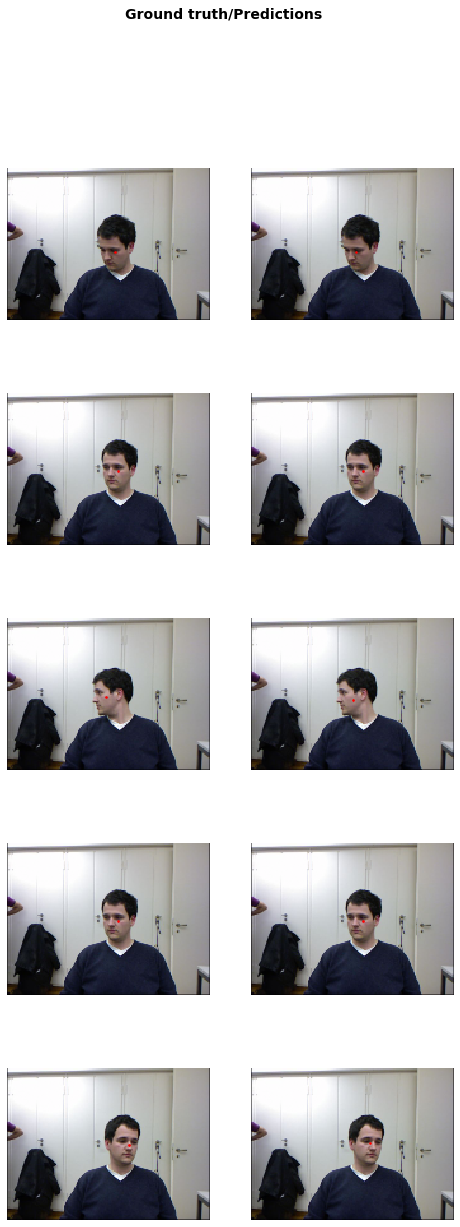

In [34]:
learn.show_results()

## *Data Augmentation*

En las siguentes celdas podemos probar como rinde el modelo realizando algunas modificaciones. En 'tfms' realizamos nuevas transformaciones y volvemos a crear el dataset.

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.5, max_lighting=0.5, max_warp=0.4, p_affine=1., p_lighting=1.)

data = (PointsItemList.from_folder(path)
       .split_by_valid_func(lambda o: o.parent.name='13')
       .label_from_func(get_ctr)
       .transform(tfms, tfm_y=True, size=(120,160))
       .databunch().normalize(imagenet_stats))

In [0]:
def _plot(i,j,ax):
    x,y = data.train_ds[0]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,6))